In [6]:
import pandas as pd
import numpy as np
from datetime import date
from tqdm.auto import tqdm
from zipfile import ZipFile

import os
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import sys
from pathlib import Path
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
try:
    df = pd.read_csv(parent + '/data/applicable_trials_2021-05-14.csv')
    print(f'Existing data loaded sucessfully! {len(df)} trials in this dataset.')
    
except FileNotFoundError:
    old_fda = parent + '/data/fdaaa_regulatory_snapshot.csv'
    
    #This data is the full ClinicalTrials.gov dataset for 14 May 2021.
    #Due to size, this is not in our GitHub repo, but stored on Dropbox 
    #You should also be able to download the raw data using this URL
    path = 'https://www.dropbox.com/s/ovzhmefl5o7pip1/clinicaltrials_raw_clincialtrials_json_2021-05-14.csv.zip?dl=1'

    from lib.data_functions import fda_reg, get_data

    fda_reg_dict = fda_reg(old_fda)
    lines = get_data(path, '2021-05-14')

    #headers is just the list of header names to save space here
    from lib.final_df import make_row, make_dataframe, headers

    #Just pACTs/ACTs
    df = make_dataframe(tqdm(lines), fda_reg_dict, headers, act_filter=True, scrape_date = date(2021,5,14))
    
    #We won't need this anymore so deleting to save some memory
    del lines
    
    #Uncomment this to save as a csv as appropriate
    df.to_csv(parent + '/data/applicable_trials_2021-05-14.csv', index=False)

Existing data loaded sucessfully! 29238 trials in this dataset.


In [32]:
df.columns

Index(['nct_id', 'act_flag', 'included_pact_flag', 'results_due',
       'has_results', 'pending_results', 'pending_data', 'has_certificate',
       'late_cert', 'certificate_date', 'certificate_date_qc',
       'certificate_posted_date', 'primary_completion_date', 'completion_date',
       'available_completion_date', 'due_date', 'last_updated_date',
       'last_verified_date', 'results_first_submitted_date',
       'results_submitted_date_qc', 'results_first_posted_date',
       'first_results_submission_any', 'study_first_submitted_date',
       'study_submitted_date_qc', 'study_first_posted_date', 'documents',
       'sponsor', 'sponsor_type', 'phase', 'location', 'study_status',
       'study_type', 'primary_purpose', 'fda_reg_drug', 'fda_reg_device',
       'is_fda_regulated', 'discrep_date_status', 'defaulted_date',
       'collaborators', 'start_date', 'used_primary_completion_date',
       'defaulted_pcd_flag', 'defaulted_cd_flag', 'intervention_types'],
      dtype='object')

In [33]:
#Making sure date columns are dates
date_cols = ['certificate_date', "certificate_date_qc", "certificate_posted_date", 'primary_completion_date', 'completion_date', 
             'available_completion_date', 'due_date', 'last_updated_date', 'last_verified_date', 'results_first_submitted_date', 
             'results_submitted_date_qc', 'results_first_posted_date',  'first_results_submission_any', 
             'study_first_submitted_date', 'study_submitted_date_qc', 'study_first_posted_date', 'start_date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [34]:
def get_weeks(df, start_dt, end_dt):
    results = df[(df.first_results_submission_any > pd.to_datetime(start_dt)) & 
                  (df.first_results_submission_any <= pd.to_datetime(end_dt))][['nct_id', 
                                                                                      'first_results_submission_any']]
    
    grouped = results.groupby('first_results_submission_any', as_index=False).count()
    weeks = grouped.resample('W-WED', on='first_results_submission_any').sum().reset_index()
    weeks.index = range(1,len(weeks)+1)
    return weeks

In [35]:
weeks_2021 = get_weeks(df, '2020-12-30', '2021-05-12')
weeks_2020 = get_weeks(df, '2020-01-01', '2020-05-13')
weeks_2019 = get_weeks(df, '2019-01-02', '2019-05-15')

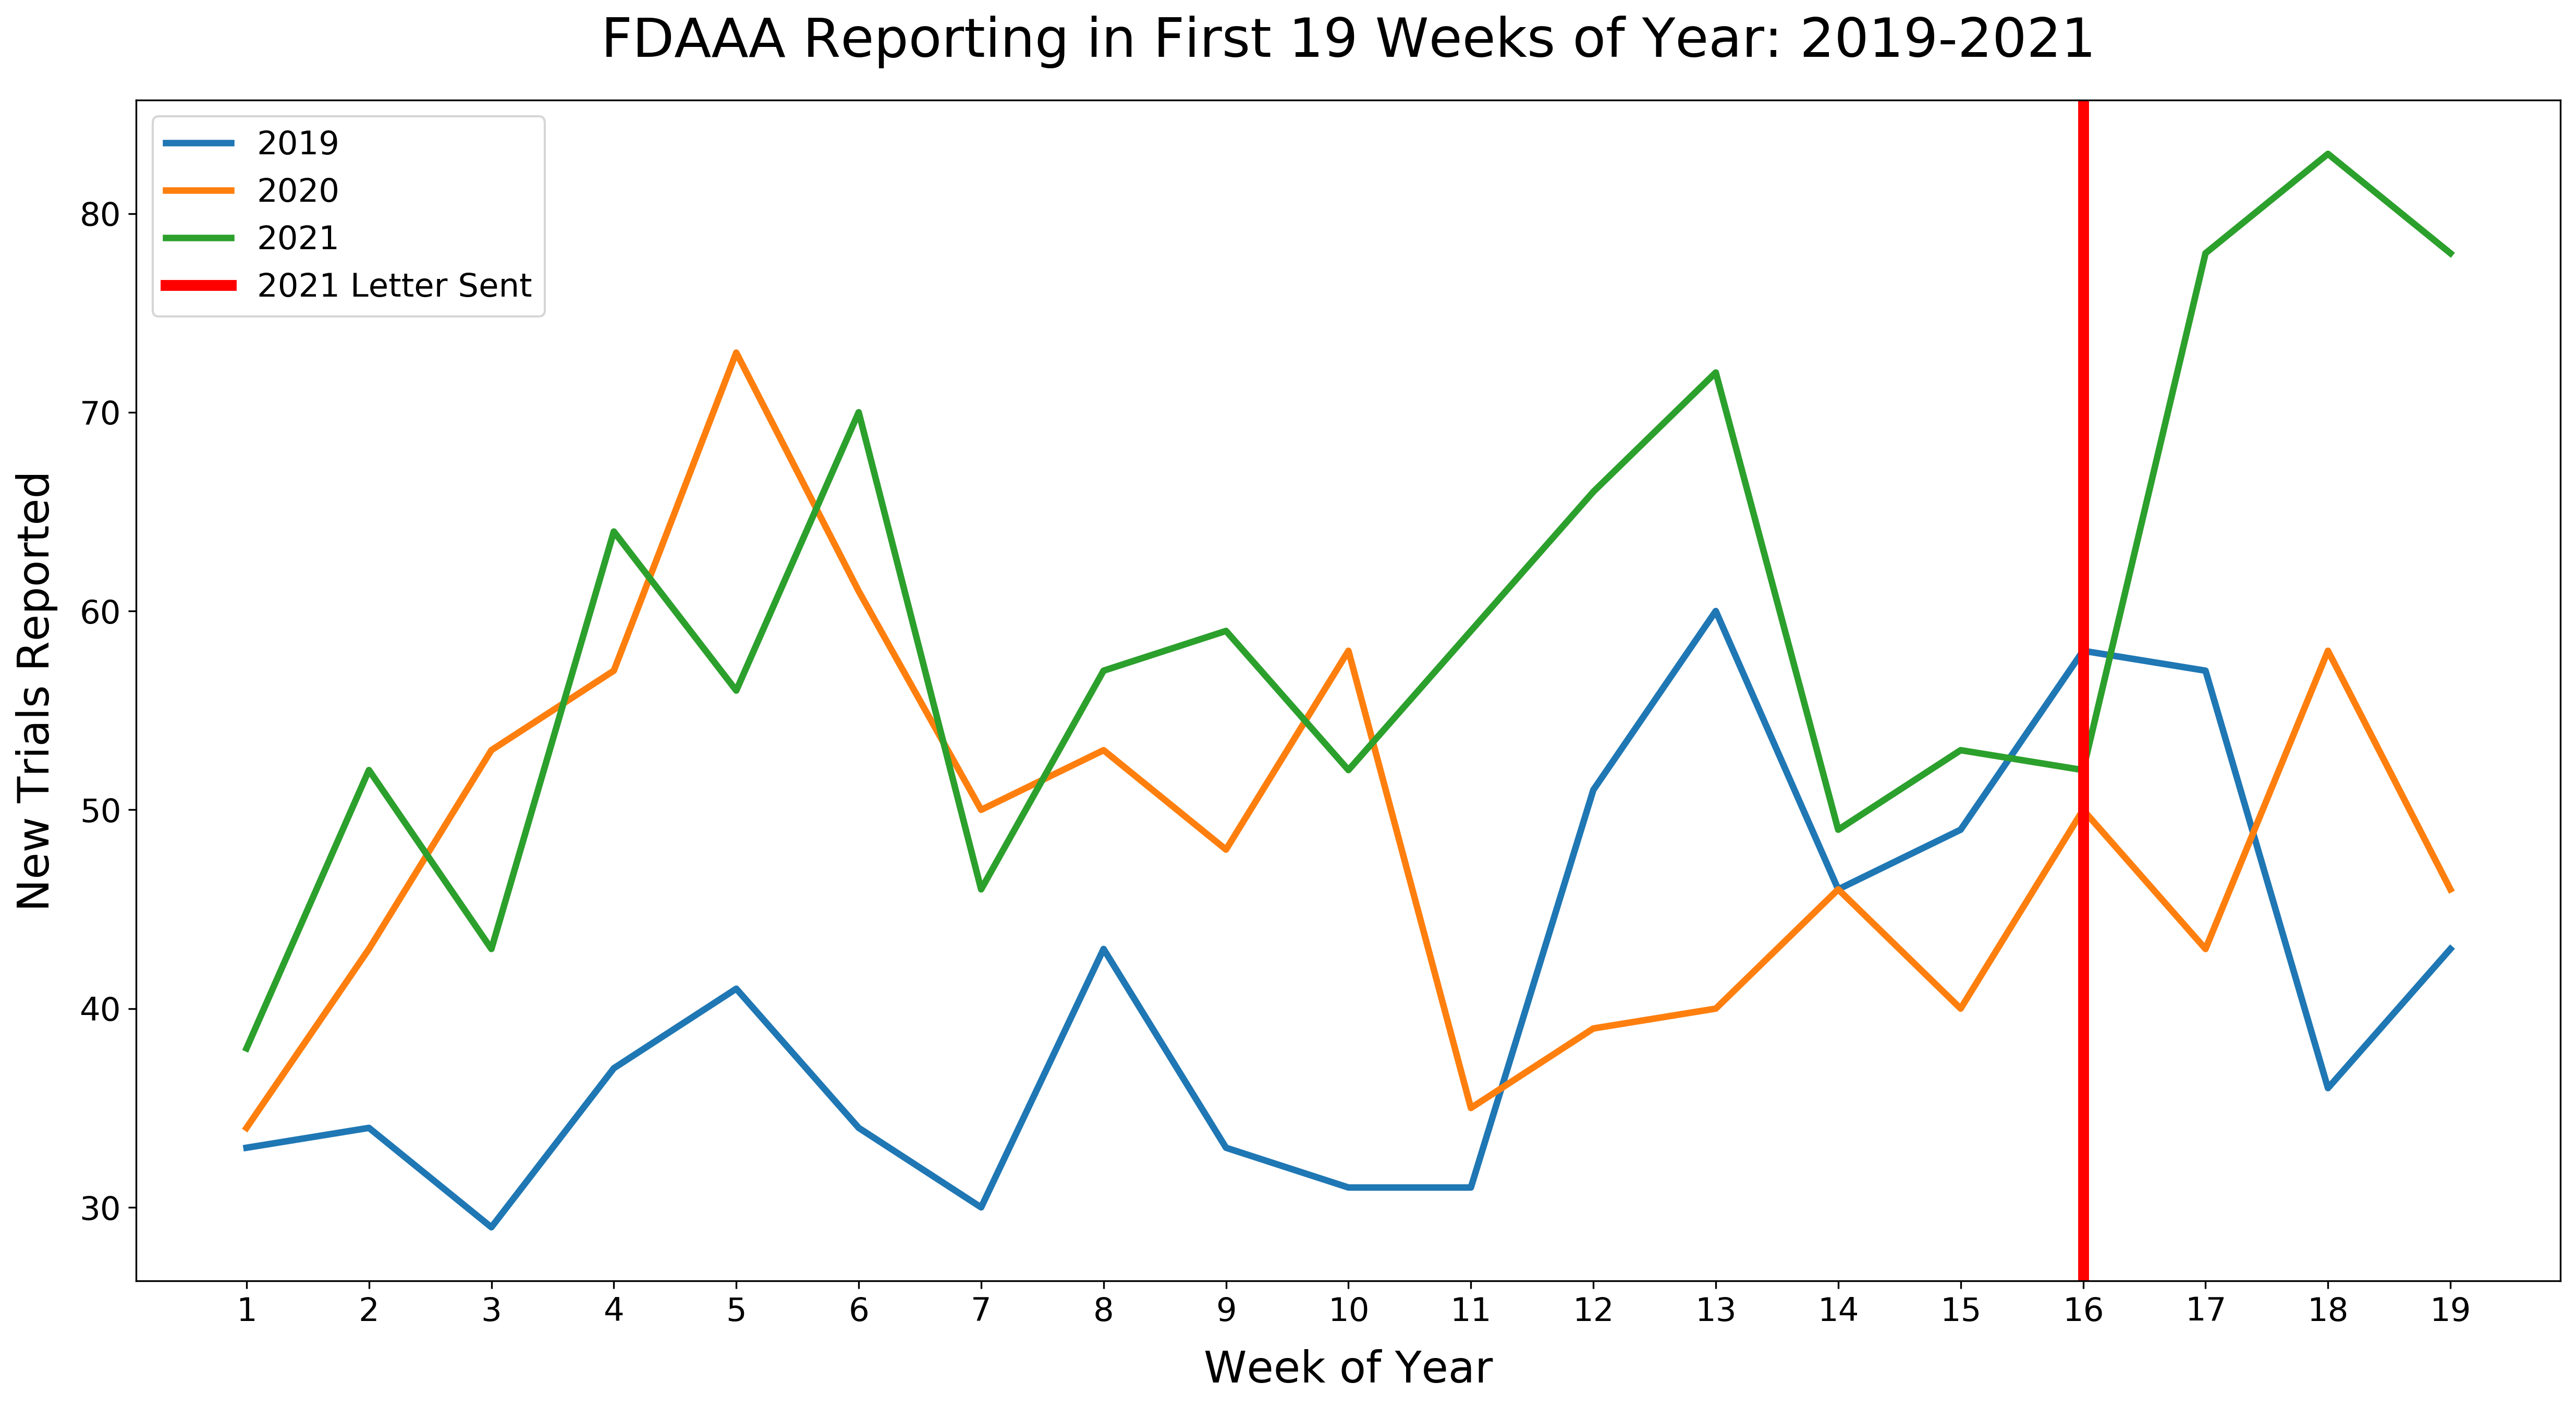

In [36]:
fig, ax = plt.subplots(figsize = (20, 10), dpi=300)

weeks_2019['nct_id'].plot(ax=ax, xticks=weeks_2019.index, label='2019', lw=3)
weeks_2020['nct_id'].plot(ax=ax, label='2020', lw=3)
weeks_2021['nct_id'].plot(ax=ax, label='2021', lw=3)

plt.axvline(x=16, color='red', label='2021 Letter Sent', lw=5)

plt.legend(loc='upper left', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

ax.set_xlabel('Week of Year', fontsize=20, labelpad=10)
ax.set_ylabel('New Trials Reported', fontsize=20, labelpad=10)

plt.title("FDAAA Reporting in First 19 Weeks of Year: 2019-2021", pad = 20, fontsize = 25)

plt.show()

Now what if we only look at overdue trials that reported?

In [37]:
df['reported_late'] = np.where(((df.due_date < df.first_results_submission_any) & df.first_results_submission_any.notnull()), 1, 0)
late_df = df[df['reported_late'] == 1][['nct_id', 'first_results_submission_any']].reset_index(drop=True)

In [38]:
weeks_2021_late = get_weeks(late_df, '2020-12-30', '2021-05-12')
weeks_2020_late = get_weeks(late_df, '2020-01-01', '2020-05-13')
weeks_2019_late = get_weeks(late_df, '2019-01-02', '2019-05-15')

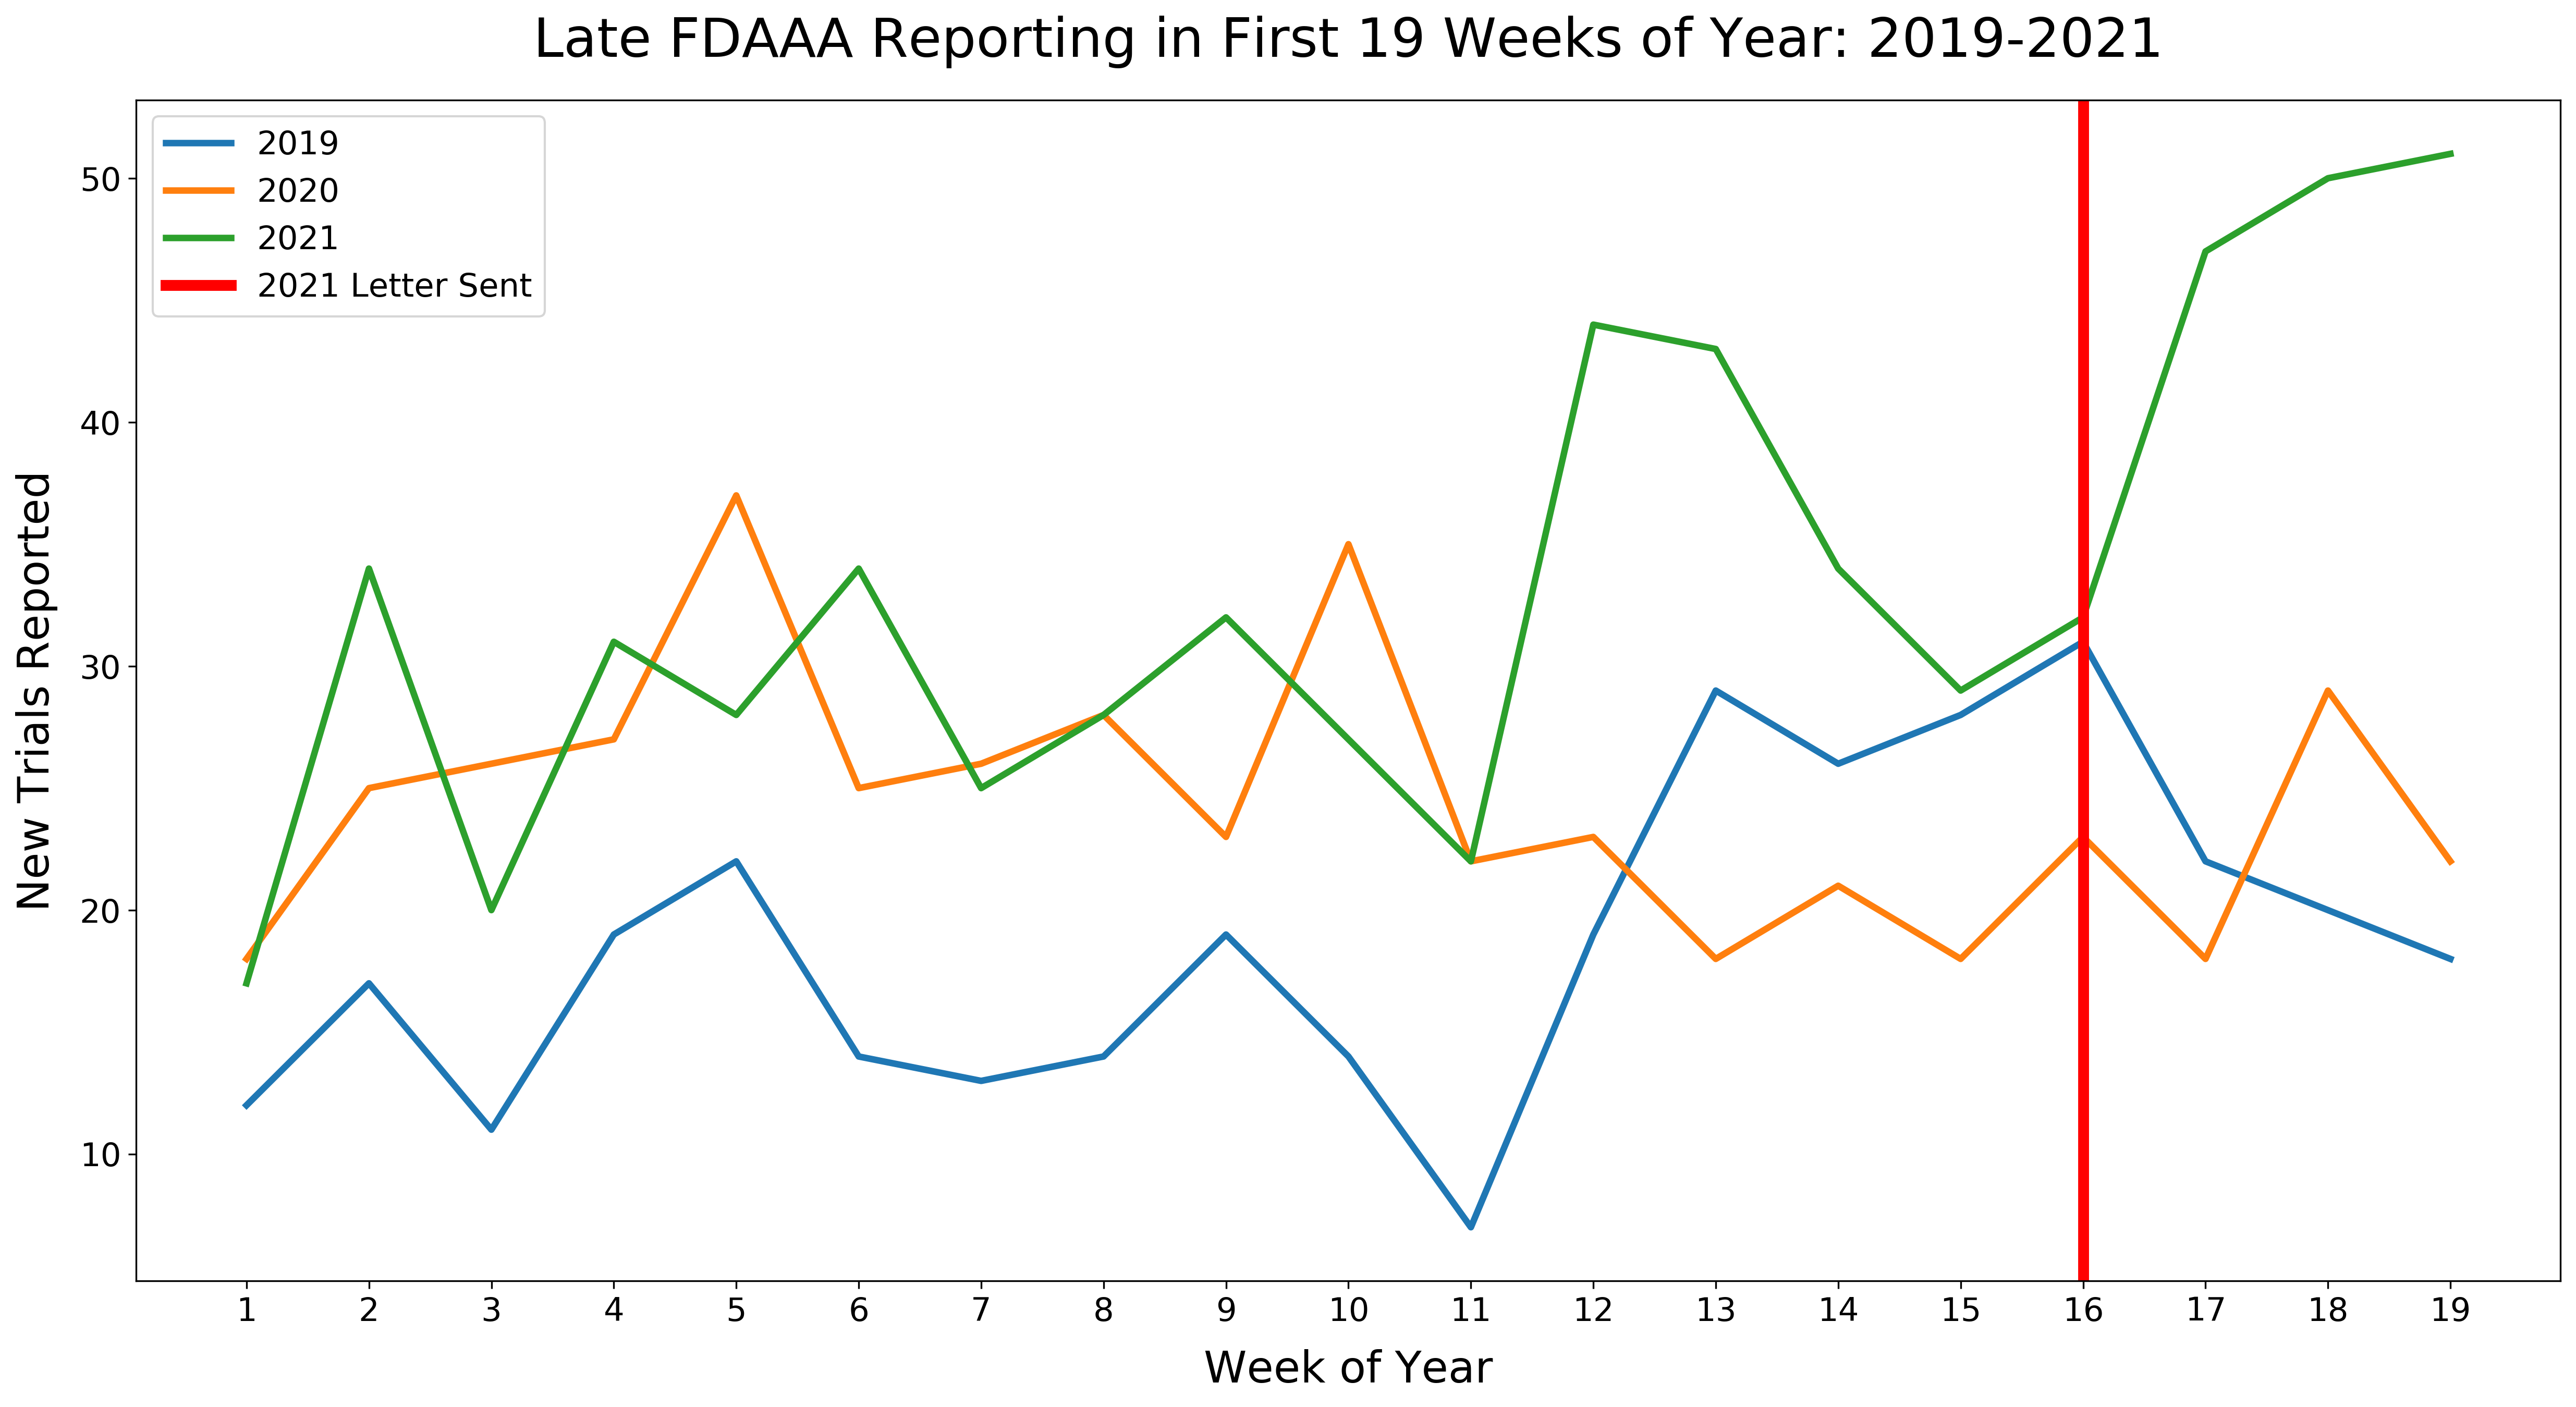

In [39]:
fig, ax = plt.subplots(figsize = (20, 10), dpi=300)

weeks_2019_late['nct_id'].plot(ax=ax, xticks=weeks_2019.index, label='2019', lw=3)
weeks_2020_late['nct_id'].plot(ax=ax, label='2020', lw=3)
weeks_2021_late['nct_id'].plot(ax=ax, label='2021', lw=3)

plt.axvline(x=16, color='red', label='2021 Letter Sent', lw=5)

plt.legend(loc='upper left', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

ax.set_xlabel('Week of Year', fontsize=20, labelpad=10)
ax.set_ylabel('New Trials Reported', fontsize=20, labelpad=10)

plt.title("Late FDAAA Reporting in First 19 Weeks of Year: 2019-2021", pad = 20, fontsize = 25)

plt.show()

# Recreating Figure from Lancet paper

In [25]:
#This cell pulls out counts for each month based on the processed data.

#Lists for statistics of interest
reported_by_month_all = []
reported_by_month_on_time = []
due_by_month  = []
reporting_prcts = []
overdue_by_month = []

#QA data manually scraped for due trials before this data was included in the ClinicalTrials.gov XML in May 2018.
qa = pd.read_csv(parent+'/data/qa.csv')
qa.submitted_to_regulator = pd.to_datetime(qa['submitted_to_regulator'])
grouped = qa.groupby(['registry_id']).min()

#Dates of scrapes used, on or as close to mid-month available. Edit this as appropriate for dates of interest
scrape_dates = [date(2018,3,15), date(2018,4,16), date(2018,5,15), date(2018,6,15), date(2018,7,16), date(2018,8,13), 
                date(2018,9,14), date(2018,10,15), date(2018,11,15), date(2018,12,14), date(2019,1,15),
                date(2019,2,15), date(2019,3,15), date(2019,4,15), date(2019,5,15), date(2019,6,13), date(2019,7,15),
                date(2019,8,15), date(2019,9,16), date(2019,10,15), date(2019,11,15), date(2019,12,15), 
                date(2020,1,15), date(2020,2,14), date(2020,3,16), date(2020,4,15), date(2020,5,15), 
                date(2020,6,15), date(2020,7,15), date(2020,8,14), date(2020,9,15), date(2020,10,15), 
                date(2020,11,16), date(2020,12,15), date(2021,1,15), date(2021,2,15), date(2021,3,15), 
                date(2021,4,15), date(2021,5,14)]

#Location of previously processed CSVs.
path2 = parent +'/data' #processed files should be here or edit as appropriate to point to their local location
files = os.listdir(path2)
files.sort()

#removing hidden file when analysis is performed on a Mac
if '.DS_Store' in files:
    files.remove('.DS_Store')
files.remove('.gitkeep')
files.remove('fdaaa_regulatory_snapshot.csv')
files.remove('qa.csv')

#Importing custom function to get summary data
from lib.summary_data import get_summary_data, ci_calc

#This loops through all the processed files, and produces the relevant statistics of interest for each date. 
#Data from before the availability of QA details in the XML are handled using 'qa' data we manually maintained through scrapes
#Data is processed via the `get_summary_data` function imported above
for file, scrape_date in zip(tqdm(files), scrape_dates):
    df = pd.read_csv(os.path.join(path2, file), low_memory=False)
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['results_first_submitted_date'] = pd.to_datetime(df['results_first_submitted_date'])
    df['first_results_submission_any'] = pd.to_datetime(df['first_results_submission_any'])
    numerator, denominator, number_on_time = get_summary_data(df,scrape_date,grouped)
    reported_by_month_all.append(numerator)
    due_by_month.append(denominator)
    overdue_by_month.append(denominator - numerator)
    reporting_prcts.append(round((numerator/denominator)*100,2))
    reported_by_month_on_time.append(number_on_time)
    
#calculates percents for reporting on-time.
prct_on_time = []
for a, b, in zip(reported_by_month_on_time, due_by_month):
    prct_on_time.append(round((a/b)*100,2))

line_errors = ci_calc(reported_by_month_all, due_by_month)

line_errors_on_time = ci_calc(reported_by_month_on_time, due_by_month)

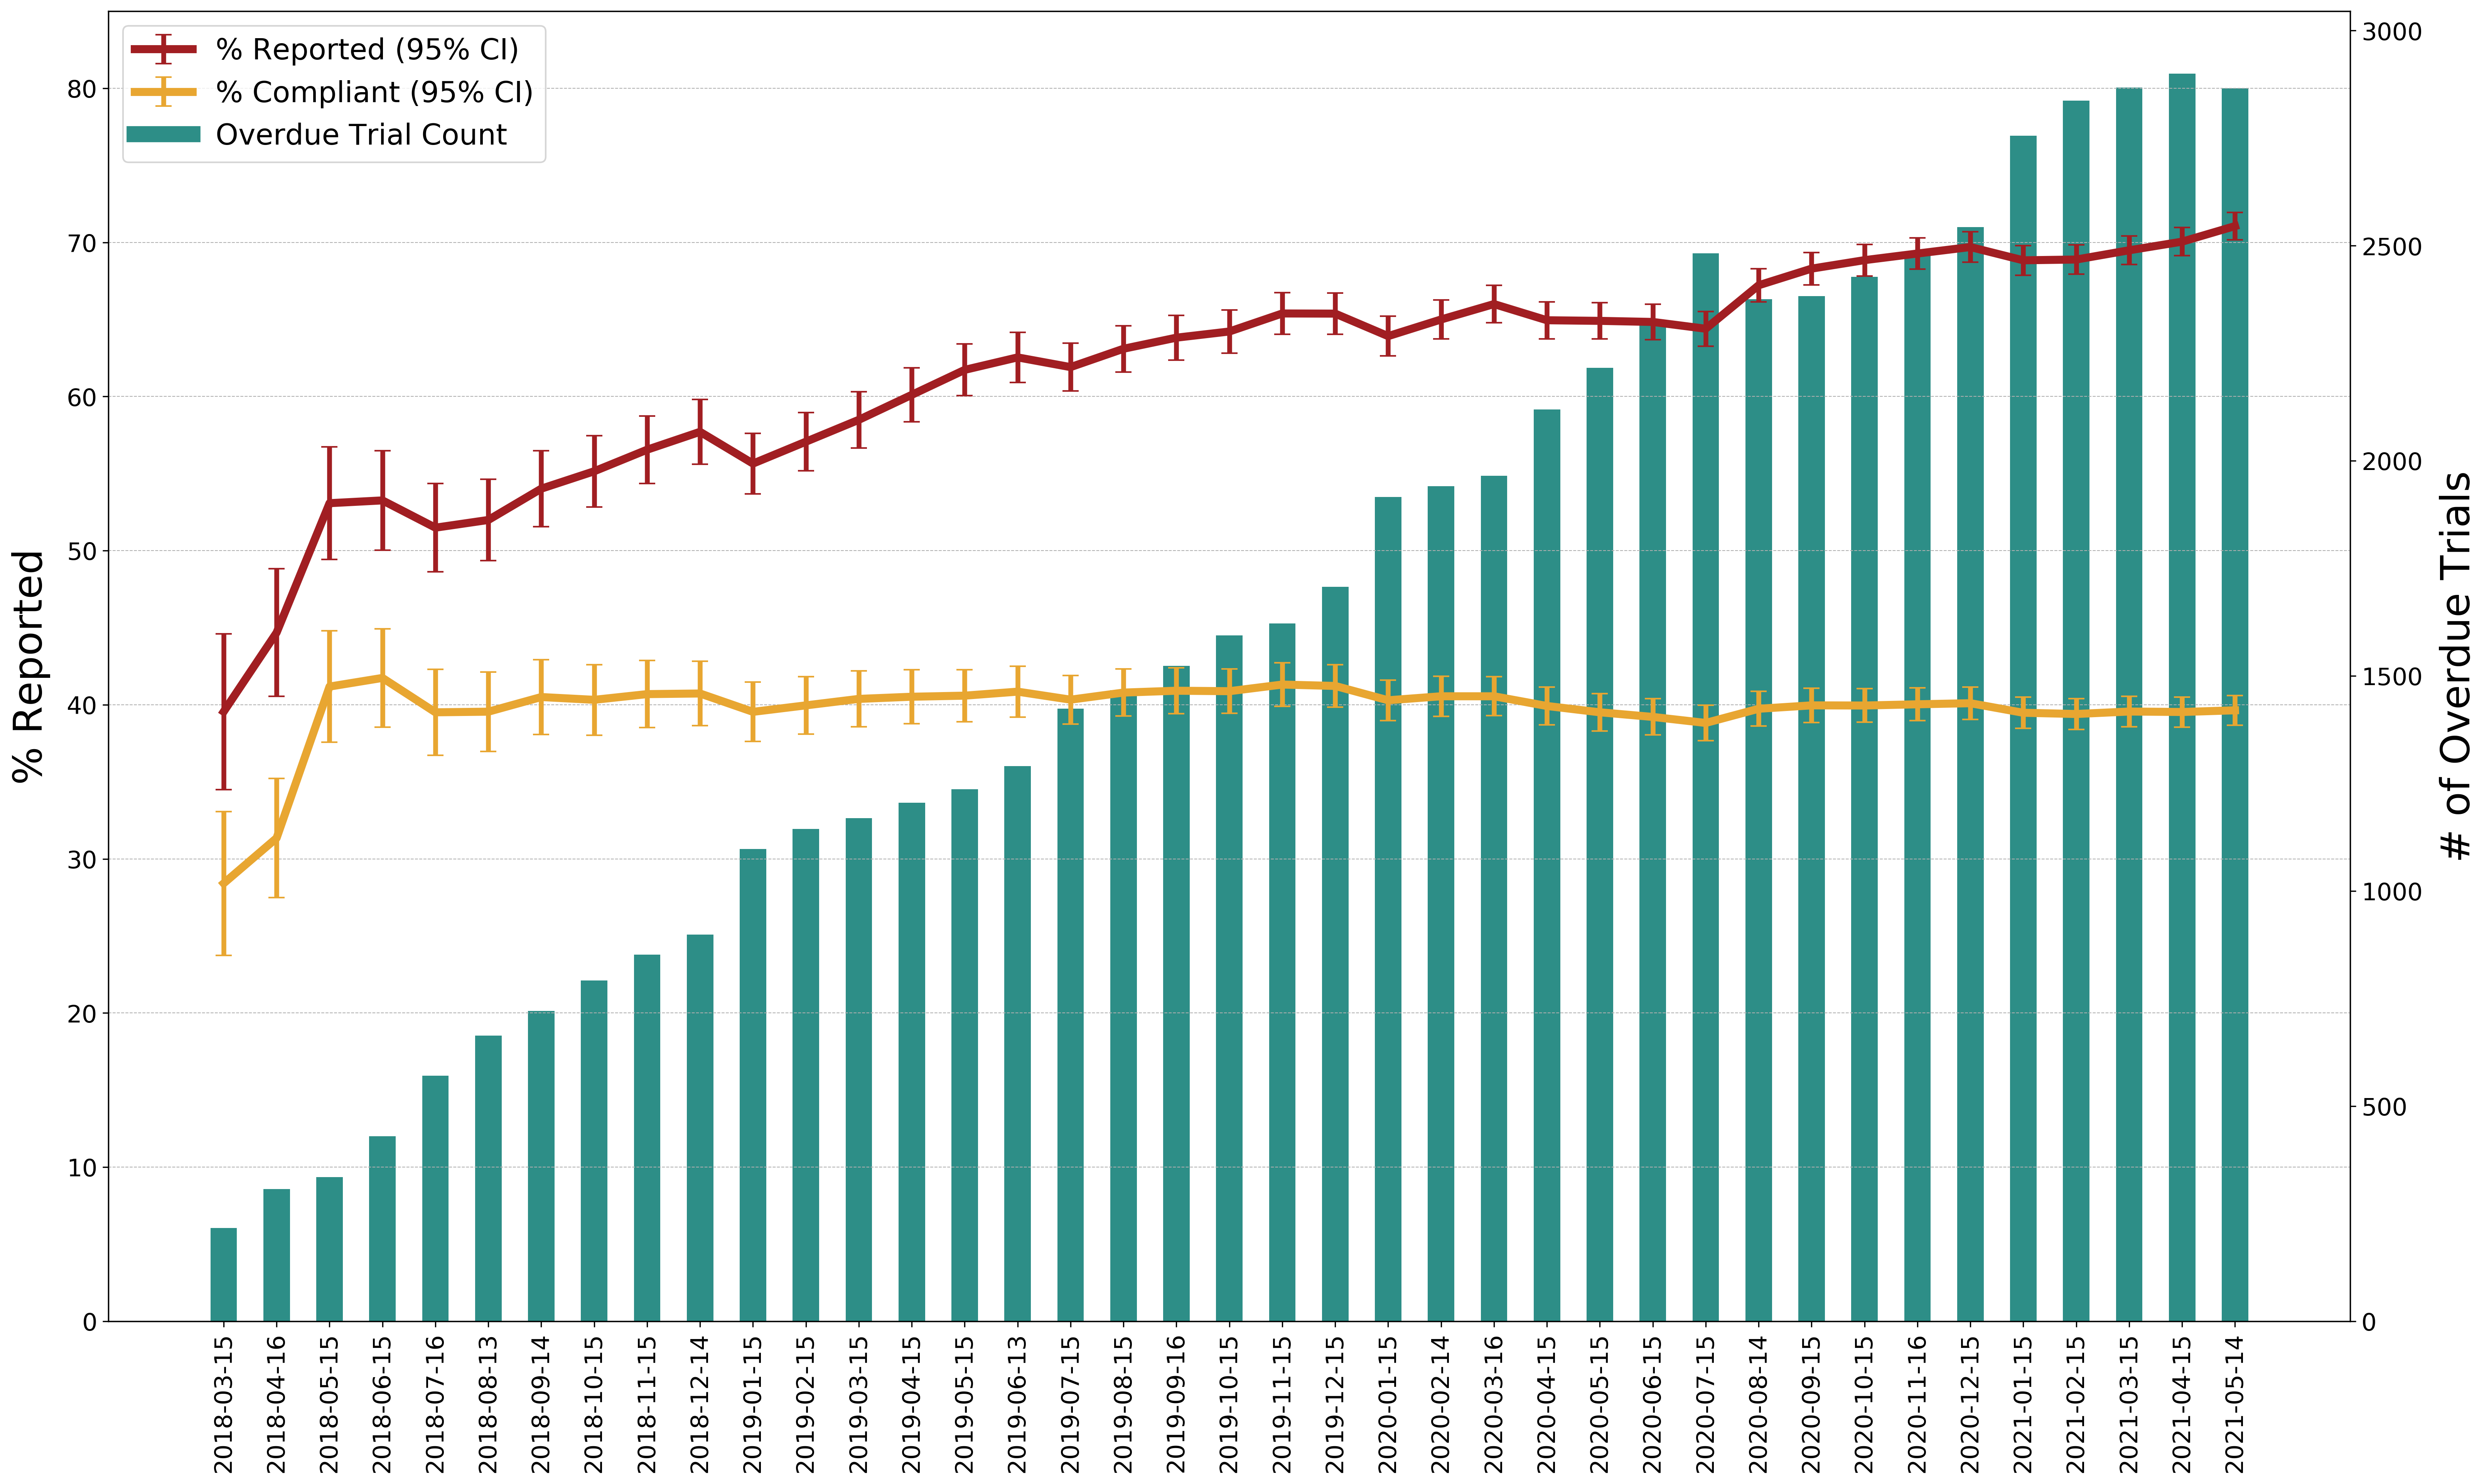

In [30]:
#creates graph of reporting, and reporting in compliance percentage as a line over a bar graph of overdue trials by month

fig, ax = plt.subplots(figsize=(25,15), dpi = 300)
index = np.arange(len(scrape_dates))
l1 = plt.errorbar(index,reporting_prcts, yerr=line_errors, elinewidth = 3, capsize=5, c = '#A11E22', lw=5)
l2 = plt.errorbar(index,prct_on_time, yerr=line_errors_on_time, elinewidth = 3, capsize=5, c = '#E8A631', lw=5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('% Reported', fontsize=25, labelpad=10)
plt.xticks(rotation=90)
#plt.title("Reporting Percentage and Overdue Trials By Month", pad = 20, fontsize = 30)
l3 = Line2D([0], [0], color='#2D8E87', ls='-', lw=10)
plt.legend((l1, l2, l3), ('% Reported (95% CI)', '% Compliant (95% CI)', 'Overdue Trial Count'), loc=2, fontsize=18)
ax.set_ylim([0,85])

ax2 = plt.twinx()
ax2.set_axisbelow(True)
ax.yaxis.grid(linestyle='--', linewidth=.5, zorder=ax.get_zorder()-10)
ax2.bar(index, overdue_by_month, capsize=5, tick_label = scrape_dates, color='#2D8E87', width=.5)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('# of Overdue Trials', fontsize=25, labelpad=10)

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)